In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format


# 데이터 로드 및 전처리
file_path = "dataset/seoul_pm10.csv"  # 데이터 파일 경로
df = pd.read_csv(file_path, encoding='cp949')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')


In [30]:
# 강남구 데이터만 선택하고 NaN 처리
gangnam_data = df[df['area'] == '강남구'][['date', 'pm10']].set_index('date')
gangnam_data = gangnam_data.fillna(method='ffill').fillna(method='bfill')  # NaN 처리


C:\Users\human-28\AppData\Local\Temp\ipykernel_54912\233757086.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gangnam_data = gangnam_data.fillna(method='ffill').fillna(method='bfill')  # NaN 처리


In [31]:
# 이상치 제거 (선택사항)
Q1 = gangnam_data['pm10'].quantile(0.25)
Q3 = gangnam_data['pm10'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
gangnam_data = gangnam_data[(gangnam_data['pm10'] >= lower_bound) & (gangnam_data['pm10'] <= upper_bound)]

In [32]:
# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(gangnam_data)


In [33]:
# 시계열 데이터셋 생성 함수
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


In [34]:
# 데이터셋 생성
time_steps = 24  # 24시간 데이터로 다음 시간 예측
X, y = create_dataset(scaled_data, time_steps)

In [35]:
# 학습/테스트 데이터 분할
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [36]:
# 데이터 reshape (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [37]:
# LSTM 모델 생성
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

c:\HJY310\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# 모델 학습
history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=32, #한 번에 처리할 샘플의 개수(미니 배치 크기)
                   validation_split=0.1, #훈련 데이터의 10%를 검증 데이터로 사용
                   verbose=1)


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0636 - val_loss: 0.0085
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

In [39]:
# 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [40]:
# 예측값 역정규화
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

실제값과 예측값의 평균 차이: 3.0506258571176508
실제값과 예측값의 최대 차이: 28.175556182861328


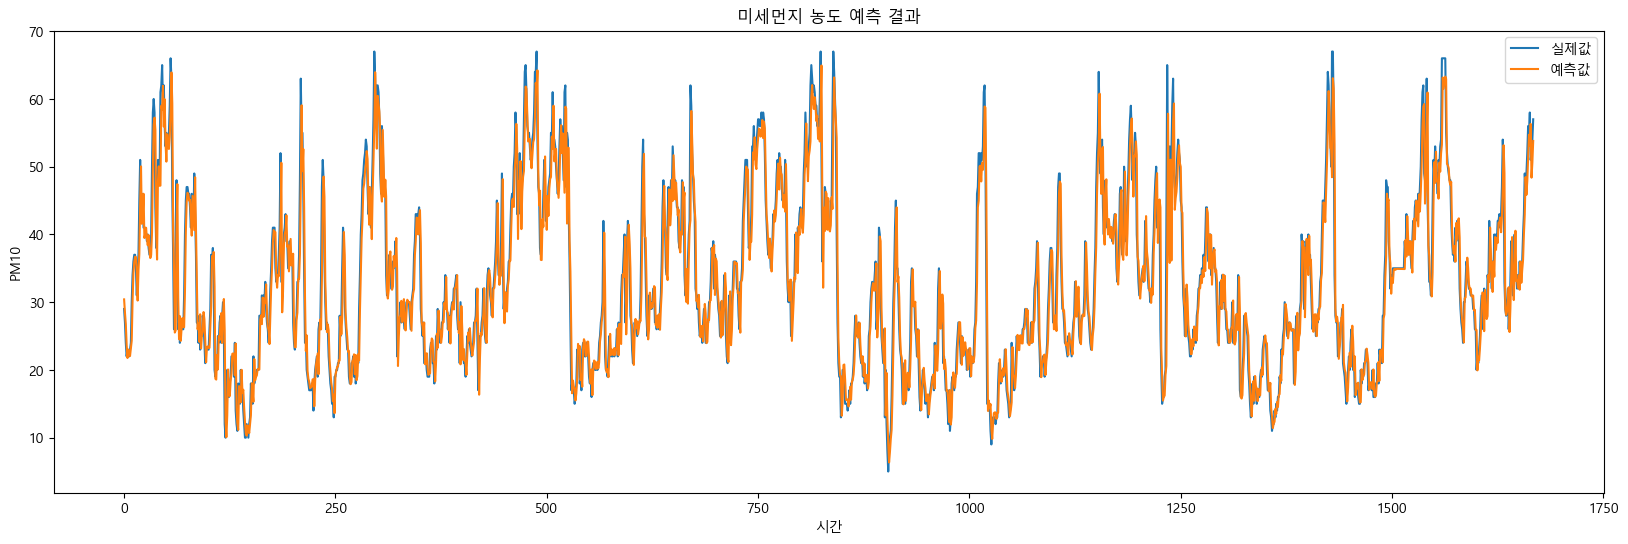

In [43]:
# 방법 1: 실제값과 예측값의 차이 확인
print("실제값과 예측값의 평균 차이:", np.mean(np.abs(y_test_inv.T - test_predict)))
print("실제값과 예측값의 최대 차이:", np.max(np.abs(y_test_inv.T - test_predict)))
# 결과 시각화
plt.figure(figsize=(20,6)) #12,6 너무 눈아픔
plt.plot(y_test_inv.T, label='실제값')
plt.plot(test_predict, label='예측값')
plt.title('미세먼지 농도 예측 결과')
plt.xlabel('시간')
plt.ylabel('PM10')
plt.legend()
plt.show()

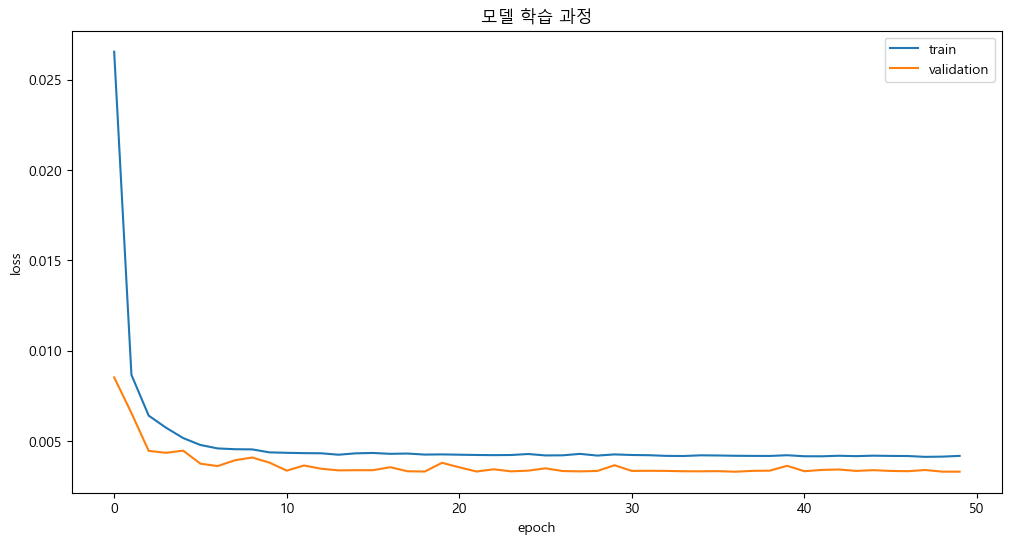

In [42]:
# 학습 과정 시각화
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('모델 학습 과정')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()